<a href="https://colab.research.google.com/github/valy3124/SupervisedLearning/blob/main/Lab_Lung_Cancer_Segmentation_DiceLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
!pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.6 MB/s eta 0:00:00


# !python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
!pip install einops
!python -c "import monai" || pip install 'monai[all]'

In [2]:
# !python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
!pip install einops
!python -c "import monai" || pip install 'monai[all]'

2024-11-13 10:09:22.441291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 10:09:22.458478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 10:09:22.463110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 10:09:22.475562: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 10:09:23.716264: W tensorflow/compiler/tf2

# Import libraries

In [3]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

import monai
# monai.config.print_config()

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.utils import first, set_determinism
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    LoadImage,
    LoadImageD,
    EnsureChannelFirstD,
    ScaleIntensityD,
    ToTensorD,
    Compose,
    AsDiscreteD,
    SpacingD,
    OrientationD,
    ResizeD,
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensityD,
    ResizeD,
    RandAffineD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ToTensorD,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [4]:
cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0

print('You are using gpu if true, cpu if false:', cuda)

You are using gpu if true, cpu if false: True


## Test data

În MONAI, există clase dedicate pentru gestionarea seturilor de date medicale standardizate, precum DecathlonDataset.

Aceste clase facilitează preprocesarea și accesul la date pentru diverse sarcini de învățare automată în imagistica medicală. Mai jos este un exemplu de cod în care utilizăm clasa DecathlonDataset pentru a descărca și încărca datele aferente sarcinii de segmentare a cancerului de plămâni (Task06_Lung).

Acest cod descarcă automat datele Task06_Lung (dedicate segmentării plămânilor) în directorul specificat și permite accesul direct la ele prin obiectul dataset. Astfel, putem accesa rapid numărul total de sample-uri și datele unui subiect individual.

In [5]:
# Dowload data, src: http://medicaldecathlon.com/
dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "training",
                           transform = None, download = True)
print(f"\nnumber of subjects: {len(dataset)}.\nThe first element in the dataset is {dataset[0]}.")

Task06_Lung.tar: 8.53GB [03:04, 49.7MB/s]                            

2024-11-13 10:12:43,392 - INFO - Downloaded: Task06_Lung.tar


2024-11-13 10:13:27,465 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2024-11-13 10:13:27,471 - INFO - Writing into directory: ..


Loading dataset: 100%|██████████| 51/51 [00:00<00:00, 346131.88it/s]


number of subjects: 51.
The first element in the dataset is {'image': 'Task06_Lung/imagesTr/lung_014.nii.gz', 'label': 'Task06_Lung/labelsTr/lung_014.nii.gz'}.


În MONAI, încărcarea imaginilor poate fi realizată folosind o abordare de tip "lazy loading," care permite încărcarea efectivă a datelor doar atunci când sunt necesare. Acest lucru este esențial în lucrul cu date medicale de mari dimensiuni, deoarece economisește memorie și timp, mai ales în scenarii de antrenare și validare, unde nu este necesar să avem toate datele încărcate simultan în memorie.

În exemplul de mai jos, folosim LoadImageD pentru a încărca o imagine și eticheta sa asociată specificate prin calea fișierului. Aceasta ne permite să verificăm forma imaginii și a etichetei, asigurându-ne că datele sunt compatibile cu modelul de segmentare.

In [6]:
# Load random to check
loader = LoadImageD(keys=("image", "label"))
data_check = loader({"image": "Task06_Lung/imagesTr/lung_014.nii.gz",
                     "label": "Task06_Lung/labelsTr/lung_014.nii.gz"})
print(f"image shape: {data_check['image'].shape} \nlabel shape: {data_check['label'].shape}")

image shape: torch.Size([512, 512, 589]) 
label shape: torch.Size([512, 512, 589])


Vizualizarea imaginilor și a etichetelor de segmentare este un pas important în pregătirea datelor pentru a ne asigura că acestea sunt corect aliniate și că structurile de interes sunt bine definite. În codul de mai jos, alegem un slice specific dintr-o imagine 3D și îl afișăm alături de eticheta sa de segmentare. Folosim imshow din matplotlib pentru a vizualiza secțiunea din imagine în tonuri de gri și pentru a suprapune eticheta în culori, folosind transparența (cu alpha = 0.5). Această suprapunere permite o comparație vizuală între structura segmentată și masca etichetată.

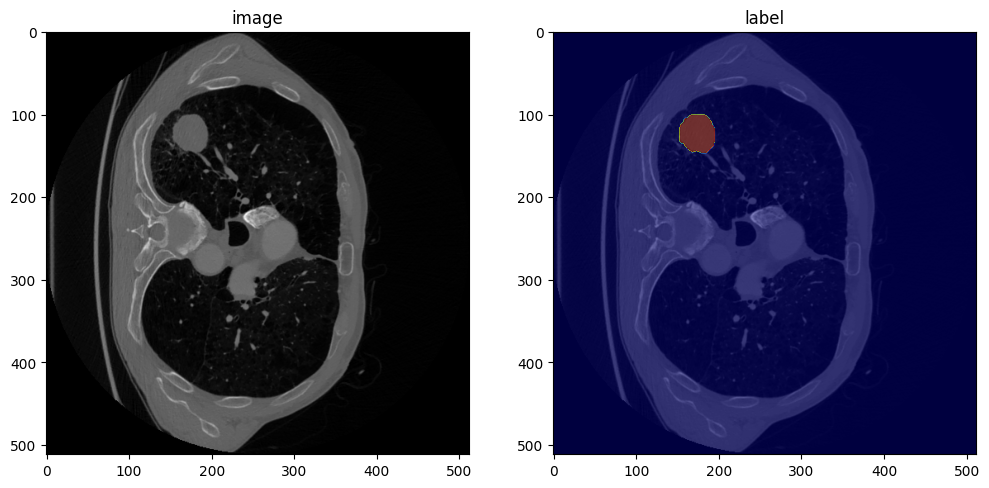

In [7]:
# Visualize check image and label
slide = 379
plt.figure("check", (12, 6))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")
plt.imshow(data_check['label'][:, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

### Exercițiul 1

Implementați o variantă prin care să afișați o secvență de 10 slice-uri (secțiuni) la intervale egale dintr-un CT, începând de la o poziție de start prestabilită. Fiecare slice trebuie să fie afișat într-un subplot separat, iar etichetele axelor să fie ascunse pentru claritate.

Pentru fiecare slice, veți afișa suprapunerea dintre imagine și masca de segmentare (ca în exemplul anterior).

Schimbați valorile pentru poziția de start, distanța dintre slice-urile alese și rulați.

Puteți porni de la ```data_check```.

Hint: ```fig, axes = plt.subplots(1, num_slices, figsize=(20, 6))```

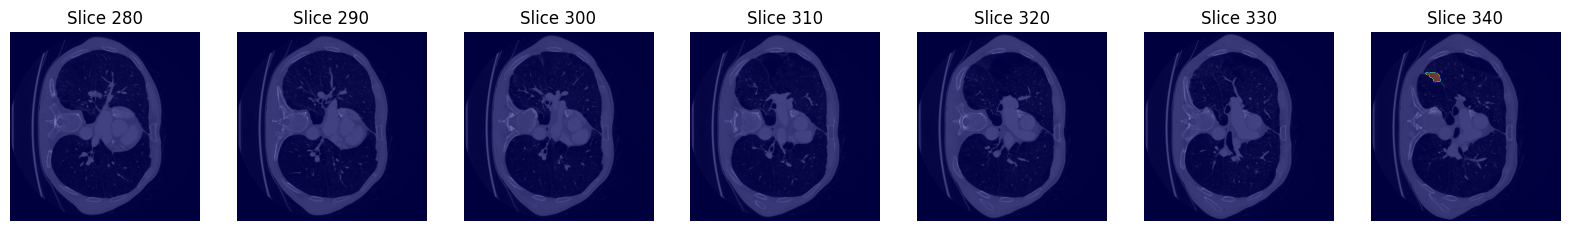

In [12]:
# TODO
num_slices = 7
fig, axes = plt.subplots(1, num_slices, figsize=(20, 6))
starting_slice = 280
for i in range(num_slices):
  axes[i].imshow(data_check['image'][:,:,starting_slice + 10*i], cmap='gray')
  axes[i].imshow(data_check['label'][:,:,starting_slice + 10*i], cmap='jet', alpha=0.5)
  axes[i].axis('off')
  axes[i].set_title(f'Slice {starting_slice + i*10}')

plt.show()

### Exercițiul 2

Aplicați o serie de transformări pe imaginea și eticheta din obiectul data_check pentru a le pregăti pentru antrenarea unui model de segmentare. Transformările trebuie să includă:



1.   Redimensionarea imaginii și etichetei la dimensiunea 256x256.
2.   Rotirea imaginii și etichetei cu 45 de grade în sensul acelor de ceasornic (Hint: ```np.pi/4```).
3. Aplicarea unui flip vertical asupra imaginii și etichetei.

Pentru testare, folosiți ```slide = 360```.



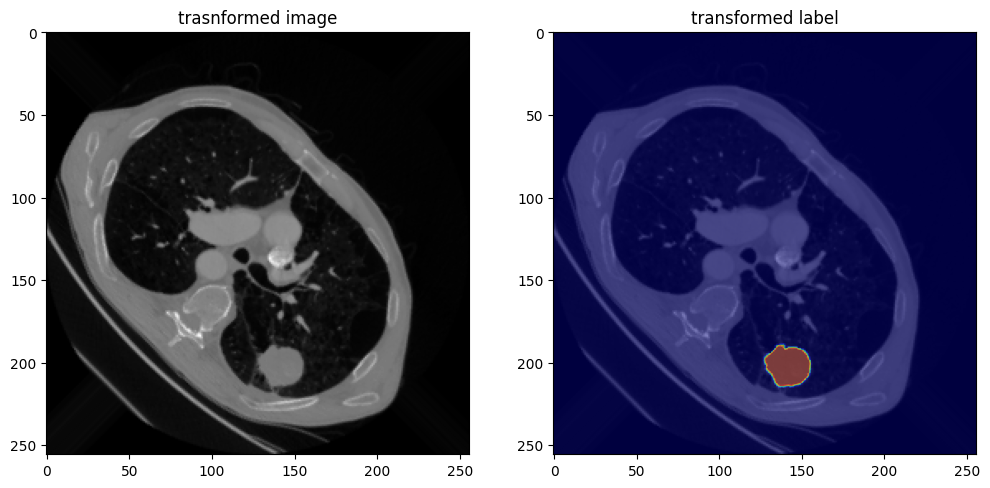

In [16]:
from monai.transforms import Resize, Rotate, Flip, Compose

transforms = Compose([
    # TODO: Definirea transformarilor
    Resize(spatial_size=(256, 256)),
    Rotate(np.pi/4),
    Flip(spatial_axis=0),
])

slide = 360
image = data_check['image'][:, :, slide].unsqueeze(0)
label = data_check['label'][:, :, slide].unsqueeze(0)

# Aplicarea transformărilor
data_transformed = {
    "image" : transforms(image),
    "label": transforms(label)
}

# TODO: plotarea imaginilor
plt.figure("transformations", (12, 6))

plt.subplot(1, 2, 1)
plt.title("trasnformed image")
plt.imshow(data_transformed['image'][0, :, :], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("transformed label")
plt.imshow(data_transformed['image'][0, :, :], cmap = "gray")
plt.imshow(data_transformed['label'][0, :, :], cmap = 'jet', alpha = 0.5)

plt.show()

### Exercițiul 3

Folosiți imaginea și eticheta pacientului (de exemplu, lung_014.nii.gz din setul de date Task06_Lung), și determinați câte slice-uri conțin țesut tumoral (adică, regiuni marcate în etichete cu valoarea 1).

Pentru acest pacient, avem deja datele stocate în ```data_check```.

In [25]:
# TODO
print(data_check['image'].shape[-1])
cancerous_count = 0
for i in range(data_check['image'].shape[-1]):
  if np.max(data_check['label'][:,:,i]) == 1:
    cancerous_count += 1
print(cancerous_count)


589
70


### Exercițiul 4

Folosiți imaginea și eticheta pacientului (de exemplu, lung_014.nii.gz din setul de date Task06_Lung), și determinați indicele slice-ului la care apare tumora cu aria maximă (adică, cea mai mare zonă marcată în etichete cu valoarea 1), precum și valoarea acestei arii.

2303
364


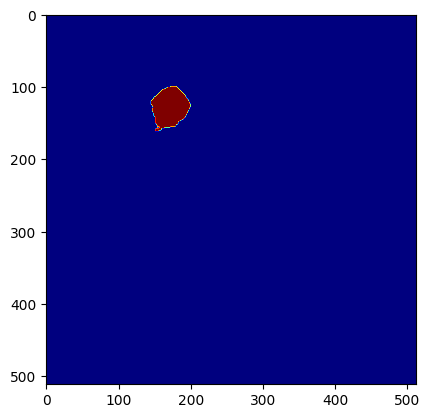

In [27]:
# TODO
max_area = 0
max_slice = 0

for i in range(data_check['image'].shape[-1]):
  cancerous_area = data_check['label'][:,:,i] > 0
  pixel_count = np.sum(cancerous_area)
  if pixel_count > max_area:
    max_area = pixel_count
    max_slice = i

print(max_area)
print(max_slice)
plt.imshow(data_check['label'][:,:,max_slice], cmap='jet')

## Load training set

In [4]:
# Set up transform
KEYS = ["image", "label"]
transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS,
             pixdim = (1., 1., 1.),
             mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS,
            (128, 128, 64),
            mode=('trilinear', 'nearest')),
    RandAffineD(keys = KEYS,
                spatial_size = (128, 128, 64),
                rotate_range = (0, 0, np.pi/12),
                scale_range = (0.1, 0.1, 0.1),
                mode = ('bilinear', 'nearest'),
                prob = 1.0),
    ToTensorD(KEYS),
])

NameError: name 'Compose' is not defined

In [ ]:
#edit transforms here
KEYS = ["image", "label"]

train_transform = Compose([
    LoadImageD(keys=KEYS),
    EnsureChannelFirstD(keys=KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys=KEYS, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')),
    ScaleIntensityD(keys="image"),
    ResizeD(KEYS, (128, 128, 64), mode=('trilinear', 'nearest')),
    RandAffineD(
        keys=KEYS,
        spatial_size=(128, 128, 64),
        rotate_range=(0, 0, np.pi/12),
        scale_range=(0.1, 0.1, 0.1),
        mode=('bilinear', 'nearest'),
        prob=0.5
    ),
    RandFlipD(keys=KEYS, spatial_axis=0, prob=0.5),
    RandRotateD(keys=KEYS, range_x=np.pi/12, range_y=np.pi/12, range_z=np.pi/12, prob=0.5),
    RandZoomD(keys=KEYS, min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ToTensorD(keys=KEYS),
])

In [ ]:
dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "training",
                           transform = transform, download = False)
train_loader = DataLoader(dataset, batch_size = 4, shuffle = True, num_workers = 8)

# Check transformed data
print(f"Length of training set: {len(train_loader)}")

check_training = first(train_loader)
training_image, training_label = check_training['image'], check_training['label']
print(f"check data training image shape: {training_image.shape} \ncheck data training label shape: {training_label.shape}")

# Trying to understand what the dimension 2 of the data is
print(training_image[0, :, 0, 0, 39])

## Load validation set

In [ ]:
# Set up transform
val_transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, pixdim = (1., 1., 1.), mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, (128, 128, 64), mode=('trilinear', 'nearest')),
    ToTensorD(KEYS),
])

# Load data
val_dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "validation",
                           transform = val_transform, download = True)

val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = True, num_workers = 4)

In [ ]:
# Check transformed data
print(f"Length of validation set: {len(val_loader)}")

check_val = first(val_loader)
val_image, val_label = check_val['image'], check_val['label']
print(f"check data image shape: {val_image.shape} \ncheck data label shape: {val_label.shape}")

# Model, Loss, Optimizer

In [ ]:
device = torch.device("cuda:0")

UNet_metadata = dict(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (64, 128, 256, 512),
    strides = (2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
)

model = UNet(**UNet_metadata).to(device) # using UNet model

loss_function = DiceLoss(to_onehot_y = True, softmax = True) # using Dice Loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # using Adam optimizer
dice_metric = DiceMetric(include_background = False, reduction = "mean")

# Start training

In [ ]:
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
metric_values = []
epoch_loss_values =[]
post_pred = Compose([AsDiscrete(argmax = True, to_onehot = 2)])
post_label = Compose([AsDiscrete(to_onehot = 2)])

for epoch in range(max_epochs):
  print("-" * 12)
  print(f"Epoch {epoch + 1}/{max_epochs}")

  # Turn model to "train" mode
  model.train()

  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
    step += 1

    input, label = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )

    # A common pytorch Deep Learning format to train model
    optimizer.zero_grad()
    output = model(input)
    loss = loss_function(output, label)
    loss.backward() # Compute gradient
    optimizer.step() # Update model's parameters

    epoch_loss += loss.item()
    print(f"{step}/{len(dataset) // train_loader.batch_size}, "
          f"train_loss: {loss.item():.4f}")

  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)

  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:
    # Turn model to "eval" mode
    model.eval()

    # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward().
    # It will reduce memory consumption for computations that would otherwise have requires_grad=True
    with torch.no_grad():
      for val_data in val_loader:
        val_input, val_label = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (128, 128, 96)
        sw_batch_size = 1

        # Set AMP for MONAI validation
        val_output = sliding_window_inference(
            val_input, roi_size, sw_batch_size, model
        )
        val_output = [post_pred(i) for i in decollate_batch(val_output)]
        val_label = [post_label(i) for i in decollate_batch(val_label)]

        # Compute metric for current iteration
        dice_metric(y_pred = val_output, y = val_label)

      # Aggregate the final mean dice result
      metric = dice_metric.aggregate().item()

      # Reset the status for the next epoch
      dice_metric.reset()

      metric_values.append(metric)
      if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        print("saved new best metric model!!!")
        torch.save(model.state_dict(), "best_metric_model.pth")

      print(
          f"current epoch: {epoch + 1},"
          f" current mean dice: {metric:.4f},"
          f" best mean dice: {best_metric:.4f},"
          f" at epoch: {best_metric_epoch}"
      )

print(
    f"train completed, best metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)

------------
Epoch 1/100
1/51, train_loss: 0.6719
2/51, train_loss: 0.6596
3/51, train_loss: 0.6432
4/51, train_loss: 0.6406
5/51, train_loss: 0.6360
6/51, train_loss: 0.6308
7/51, train_loss: 0.6269
8/51, train_loss: 0.6245
9/51, train_loss: 0.6207
10/51, train_loss: 0.6176
11/51, train_loss: 0.6155
12/51, train_loss: 0.6122
13/51, train_loss: 0.6105
14/51, train_loss: 0.6073
15/51, train_loss: 0.6043
16/51, train_loss: 0.6029
17/51, train_loss: 0.5999
18/51, train_loss: 0.5988
19/51, train_loss: 0.5958
20/51, train_loss: 0.5943
21/51, train_loss: 0.5921
22/51, train_loss: 0.5903
23/51, train_loss: 0.5871
24/51, train_loss: 0.5854
25/51, train_loss: 0.5832
26/51, train_loss: 0.5813
27/51, train_loss: 0.5789
28/51, train_loss: 0.5766
29/51, train_loss: 0.5744
30/51, train_loss: 0.5729
31/51, train_loss: 0.5704
32/51, train_loss: 0.5685
33/51, train_loss: 0.5664
34/51, train_loss: 0.5637
35/51, train_loss: 0.5621
36/51, train_loss: 0.5600
37/51, train_loss: 0.5578
38/51, train_loss: 0.5

33/51, train_loss: 0.4969
34/51, train_loss: 0.4739
35/51, train_loss: 0.4832
36/51, train_loss: 0.4981
37/51, train_loss: 0.4973
38/51, train_loss: 0.5002
39/51, train_loss: 0.4817
40/51, train_loss: 0.4394
41/51, train_loss: 0.4543
42/51, train_loss: 0.4999
43/51, train_loss: 0.4999
44/51, train_loss: 0.4992
45/51, train_loss: 0.4804
46/51, train_loss: 0.4601
47/51, train_loss: 0.4815
48/51, train_loss: 0.4981
49/51, train_loss: 0.4779
50/51, train_loss: 0.4958
51/51, train_loss: 0.5003
epoch 6 average loss: 0.4886
saved new best metric model!!!
current epoch: 6, current mean dice: 0.1179, best mean dice: 0.1179, at epoch: 6
------------
Epoch 7/100
1/51, train_loss: 0.4825
2/51, train_loss: 0.4954
3/51, train_loss: 0.4587
4/51, train_loss: 0.4963
5/51, train_loss: 0.4796
6/51, train_loss: 0.4164
7/51, train_loss: 0.5001
8/51, train_loss: 0.4586
9/51, train_loss: 0.4988
10/51, train_loss: 0.4985
11/51, train_loss: 0.5005
12/51, train_loss: 0.4997
13/51, train_loss: 0.4345
14/51, trai

9/51, train_loss: 0.2712
10/51, train_loss: 0.5000
11/51, train_loss: 0.3848
12/51, train_loss: 0.4902
13/51, train_loss: 0.4800
14/51, train_loss: 0.5007
15/51, train_loss: 0.4805
16/51, train_loss: 0.4571
17/51, train_loss: 0.4783
18/51, train_loss: 0.4853
19/51, train_loss: 0.4871
20/51, train_loss: 0.4990
21/51, train_loss: 0.4544
22/51, train_loss: 0.4881
23/51, train_loss: 0.4627
24/51, train_loss: 0.5016
25/51, train_loss: 0.5018
26/51, train_loss: 0.4271
27/51, train_loss: 0.4857
28/51, train_loss: 0.3343
29/51, train_loss: 0.1887
30/51, train_loss: 0.4757
31/51, train_loss: 0.1866
32/51, train_loss: 0.2771
33/51, train_loss: 0.3852
34/51, train_loss: 0.5000
35/51, train_loss: 0.1821
36/51, train_loss: 0.3900
37/51, train_loss: 0.3421
38/51, train_loss: 0.3894
39/51, train_loss: 0.2758
40/51, train_loss: 0.4996
41/51, train_loss: 0.5004
42/51, train_loss: 0.3549
43/51, train_loss: 0.5000
44/51, train_loss: 0.4984
45/51, train_loss: 0.3650
46/51, train_loss: 0.4838
47/51, train_

41/51, train_loss: 0.3040
42/51, train_loss: 0.5000
43/51, train_loss: 0.3499
44/51, train_loss: 0.5000
45/51, train_loss: 0.5001
46/51, train_loss: 0.4997
47/51, train_loss: 0.4655
48/51, train_loss: 0.2095
49/51, train_loss: 0.1190
50/51, train_loss: 0.3504
51/51, train_loss: 0.3699
epoch 17 average loss: 0.3165
saved new best metric model!!!
current epoch: 17, current mean dice: 0.4304, best mean dice: 0.4304, at epoch: 17
------------
Epoch 18/100
1/51, train_loss: 0.2547
2/51, train_loss: 0.2524
3/51, train_loss: 0.2766
4/51, train_loss: 0.2954
5/51, train_loss: 0.1682
6/51, train_loss: 0.3169
7/51, train_loss: 0.2027
8/51, train_loss: 0.1563
9/51, train_loss: 0.1875
10/51, train_loss: 0.1457
11/51, train_loss: 0.1082
12/51, train_loss: 0.4975
13/51, train_loss: 0.1293
14/51, train_loss: 0.4202
15/51, train_loss: 0.2908
16/51, train_loss: 0.3493
17/51, train_loss: 0.1822
18/51, train_loss: 0.3454
19/51, train_loss: 0.5000
20/51, train_loss: 0.1503
21/51, train_loss: 0.5000
22/51, 

17/51, train_loss: 0.1585
18/51, train_loss: 0.5001
19/51, train_loss: 0.1838
20/51, train_loss: 0.1910
21/51, train_loss: 0.1630
22/51, train_loss: 0.1610
23/51, train_loss: 0.5000
24/51, train_loss: 0.3330
25/51, train_loss: 0.1392
26/51, train_loss: 0.1661
27/51, train_loss: 0.1861
28/51, train_loss: 0.3489
29/51, train_loss: 0.2011
30/51, train_loss: 0.3258
31/51, train_loss: 0.5000
32/51, train_loss: 0.2493
33/51, train_loss: 0.2112
34/51, train_loss: 0.4198
35/51, train_loss: 0.3497
36/51, train_loss: 0.1583
37/51, train_loss: 0.5000
38/51, train_loss: 0.1191
39/51, train_loss: 0.3880
40/51, train_loss: 0.1845
41/51, train_loss: 0.1694
42/51, train_loss: 0.1703
43/51, train_loss: 0.4147
44/51, train_loss: 0.2159
45/51, train_loss: 0.2635
46/51, train_loss: 0.2398
47/51, train_loss: 0.2074
48/51, train_loss: 0.4597
49/51, train_loss: 0.5009
50/51, train_loss: 0.4282
51/51, train_loss: 0.2288
epoch 23 average loss: 0.2891
saved new best metric model!!!
current epoch: 23, current me

51/51, train_loss: 0.2785
epoch 28 average loss: 0.2460
current epoch: 28, current mean dice: 0.3628, best mean dice: 0.4994, at epoch: 23
------------
Epoch 29/100
1/51, train_loss: 0.1117
2/51, train_loss: 0.1345
3/51, train_loss: 0.5000
4/51, train_loss: 0.1363
5/51, train_loss: 0.1687
6/51, train_loss: 0.2793
7/51, train_loss: 0.1800
8/51, train_loss: 0.4286
9/51, train_loss: 0.1383
10/51, train_loss: 0.2904
11/51, train_loss: 0.2350
12/51, train_loss: 0.3863
13/51, train_loss: 0.5000
14/51, train_loss: 0.2023
15/51, train_loss: 0.1488
16/51, train_loss: 0.2181
17/51, train_loss: 0.4592
18/51, train_loss: 0.1656
19/51, train_loss: 0.2119
20/51, train_loss: 0.2137
21/51, train_loss: 0.1713
22/51, train_loss: 0.1550
23/51, train_loss: 0.0813
24/51, train_loss: 0.4940
25/51, train_loss: 0.1549
26/51, train_loss: 0.3023
27/51, train_loss: 0.2318
28/51, train_loss: 0.0989
29/51, train_loss: 0.5000
30/51, train_loss: 0.1062
31/51, train_loss: 0.4999
32/51, train_loss: 0.2453
33/51, train

29/51, train_loss: 0.1640
30/51, train_loss: 0.1757
31/51, train_loss: 0.1841
32/51, train_loss: 0.1385
33/51, train_loss: 0.5000
34/51, train_loss: 0.2125
35/51, train_loss: 0.2453
36/51, train_loss: 0.1292
37/51, train_loss: 0.3664
38/51, train_loss: 0.1692
39/51, train_loss: 0.5000
40/51, train_loss: 0.1934
41/51, train_loss: 0.1887
42/51, train_loss: 0.5000
43/51, train_loss: 0.5001
44/51, train_loss: 0.2806
45/51, train_loss: 0.4502
46/51, train_loss: 0.4277
47/51, train_loss: 0.2221
48/51, train_loss: 0.2266
49/51, train_loss: 0.1669
50/51, train_loss: 0.1852
51/51, train_loss: 0.1710
epoch 34 average loss: 0.2342
current epoch: 34, current mean dice: 0.4978, best mean dice: 0.5392, at epoch: 33
------------
Epoch 35/100
1/51, train_loss: 0.2689
2/51, train_loss: 0.4597
3/51, train_loss: 0.1449
4/51, train_loss: 0.1274
5/51, train_loss: 0.1455
6/51, train_loss: 0.1271
7/51, train_loss: 0.2319
8/51, train_loss: 0.1236
9/51, train_loss: 0.1777
10/51, train_loss: 0.1168
11/51, train

9/51, train_loss: 0.2201
10/51, train_loss: 0.2526
11/51, train_loss: 0.4173
12/51, train_loss: 0.1366
13/51, train_loss: 0.4231
14/51, train_loss: 0.1812
15/51, train_loss: 0.4980
16/51, train_loss: 0.1533
17/51, train_loss: 0.1710
18/51, train_loss: 0.1864
19/51, train_loss: 0.2352
20/51, train_loss: 0.5000
21/51, train_loss: 0.1999
22/51, train_loss: 0.1593
23/51, train_loss: 0.1012
24/51, train_loss: 0.1169
25/51, train_loss: 0.2261
26/51, train_loss: 0.2273
27/51, train_loss: 0.1090
28/51, train_loss: 0.2131
29/51, train_loss: 0.5000
30/51, train_loss: 0.1673
31/51, train_loss: 0.0983
32/51, train_loss: 0.4985
33/51, train_loss: 0.2243
34/51, train_loss: 0.1026
35/51, train_loss: 0.3330
36/51, train_loss: 0.2465
37/51, train_loss: 0.1339
38/51, train_loss: 0.2050
39/51, train_loss: 0.4262
40/51, train_loss: 0.0721
41/51, train_loss: 0.1911
42/51, train_loss: 0.1469
43/51, train_loss: 0.2453
44/51, train_loss: 0.2787
45/51, train_loss: 0.1197
46/51, train_loss: 0.2841
47/51, train_

45/51, train_loss: 0.1707
46/51, train_loss: 0.5000
47/51, train_loss: 0.1528
48/51, train_loss: 0.1736
49/51, train_loss: 0.5001
50/51, train_loss: 0.0827
51/51, train_loss: 0.0993
epoch 45 average loss: 0.1980
current epoch: 45, current mean dice: 0.3395, best mean dice: 0.5392, at epoch: 33
------------
Epoch 46/100
1/51, train_loss: 0.1420
2/51, train_loss: 0.1872
3/51, train_loss: 0.1510
4/51, train_loss: 0.2677
5/51, train_loss: 0.1329
6/51, train_loss: 0.1022
7/51, train_loss: 0.1198
8/51, train_loss: 0.0909
9/51, train_loss: 0.3410
10/51, train_loss: 0.2026
11/51, train_loss: 0.1419
12/51, train_loss: 0.1582
13/51, train_loss: 0.1644
14/51, train_loss: 0.1149
15/51, train_loss: 0.1308
16/51, train_loss: 0.1741
17/51, train_loss: 0.1729
18/51, train_loss: 0.0922
19/51, train_loss: 0.1165
20/51, train_loss: 0.1416
21/51, train_loss: 0.2409
22/51, train_loss: 0.1782
23/51, train_loss: 0.1730
24/51, train_loss: 0.5000
25/51, train_loss: 0.2040
26/51, train_loss: 0.0890
27/51, train

25/51, train_loss: 0.2332
26/51, train_loss: 0.1342
27/51, train_loss: 0.1916
28/51, train_loss: 0.1649
29/51, train_loss: 0.0931
30/51, train_loss: 0.1513
31/51, train_loss: 0.4278
32/51, train_loss: 0.3957
33/51, train_loss: 0.2496
34/51, train_loss: 0.1384
35/51, train_loss: 0.1489
36/51, train_loss: 0.5000
37/51, train_loss: 0.2161
38/51, train_loss: 0.0955
39/51, train_loss: 0.1672
40/51, train_loss: 0.1752
41/51, train_loss: 0.1264
42/51, train_loss: 0.0573
43/51, train_loss: 0.0953
44/51, train_loss: 0.1039
45/51, train_loss: 0.2711
46/51, train_loss: 0.1704
47/51, train_loss: 0.1712
48/51, train_loss: 0.1617
49/51, train_loss: 0.1474
50/51, train_loss: 0.1612
51/51, train_loss: 0.1855
epoch 51 average loss: 0.1906
current epoch: 51, current mean dice: 0.3991, best mean dice: 0.5392, at epoch: 33
------------
Epoch 52/100
1/51, train_loss: 0.1341
2/51, train_loss: 0.2865
3/51, train_loss: 0.1047
4/51, train_loss: 0.1328
5/51, train_loss: 0.1213
6/51, train_loss: 0.1722
7/51, tra

5/51, train_loss: 0.5000
6/51, train_loss: 0.0791
7/51, train_loss: 0.0942
8/51, train_loss: 0.2364
9/51, train_loss: 0.1748
10/51, train_loss: 0.2504
11/51, train_loss: 0.1834
12/51, train_loss: 0.1946
13/51, train_loss: 0.2015
14/51, train_loss: 0.1743
15/51, train_loss: 0.1406
16/51, train_loss: 0.1947
17/51, train_loss: 0.1054
18/51, train_loss: 0.2035
19/51, train_loss: 0.2014
20/51, train_loss: 0.1266
21/51, train_loss: 0.2225
22/51, train_loss: 0.0879
23/51, train_loss: 0.3490
24/51, train_loss: 0.1641
25/51, train_loss: 0.1311
26/51, train_loss: 0.1183
27/51, train_loss: 0.5006
28/51, train_loss: 0.0900
29/51, train_loss: 0.0704
30/51, train_loss: 0.1256
31/51, train_loss: 0.2075
32/51, train_loss: 0.1050
33/51, train_loss: 0.1427
34/51, train_loss: 0.0821
35/51, train_loss: 0.0964
36/51, train_loss: 0.2484
37/51, train_loss: 0.1711
38/51, train_loss: 0.1315
39/51, train_loss: 0.1060
40/51, train_loss: 0.1598
41/51, train_loss: 0.1483
42/51, train_loss: 0.5000
43/51, train_loss

41/51, train_loss: 0.1012
42/51, train_loss: 0.5000
43/51, train_loss: 0.1088
44/51, train_loss: 0.1966
45/51, train_loss: 0.2157
46/51, train_loss: 0.2082
47/51, train_loss: 0.5000
48/51, train_loss: 0.3265
49/51, train_loss: 0.1387
50/51, train_loss: 0.1389
51/51, train_loss: 0.1980
epoch 62 average loss: 0.1818
current epoch: 62, current mean dice: 0.4085, best mean dice: 0.5392, at epoch: 33
------------
Epoch 63/100
1/51, train_loss: 0.1442
2/51, train_loss: 0.2054
3/51, train_loss: 0.0951
4/51, train_loss: 0.1288
5/51, train_loss: 0.2057
6/51, train_loss: 0.1142
7/51, train_loss: 0.0783
8/51, train_loss: 0.1101
9/51, train_loss: 0.1455
10/51, train_loss: 0.1962
11/51, train_loss: 0.1136
12/51, train_loss: 0.1425
13/51, train_loss: 0.1600
14/51, train_loss: 0.0876
15/51, train_loss: 0.1570
16/51, train_loss: 0.2348
17/51, train_loss: 0.1193
18/51, train_loss: 0.1381
19/51, train_loss: 0.1662
20/51, train_loss: 0.4237
21/51, train_loss: 0.0786
22/51, train_loss: 0.5000
23/51, train

21/51, train_loss: 0.2396
22/51, train_loss: 0.1214
23/51, train_loss: 0.5000
24/51, train_loss: 0.1551
25/51, train_loss: 0.1737
26/51, train_loss: 0.1382
27/51, train_loss: 0.1834
28/51, train_loss: 0.1514
29/51, train_loss: 0.1425
30/51, train_loss: 0.1641
31/51, train_loss: 0.1593
32/51, train_loss: 0.0758
33/51, train_loss: 0.5000
34/51, train_loss: 0.1163
35/51, train_loss: 0.1281
36/51, train_loss: 0.1612
37/51, train_loss: 0.1630
38/51, train_loss: 0.0815
39/51, train_loss: 0.0949
40/51, train_loss: 0.1355
41/51, train_loss: 0.1627
42/51, train_loss: 0.1186
43/51, train_loss: 0.0727
44/51, train_loss: 0.0847
45/51, train_loss: 0.0956
46/51, train_loss: 0.0924
47/51, train_loss: 0.1557
48/51, train_loss: 0.2831
49/51, train_loss: 0.0854
50/51, train_loss: 0.2989
51/51, train_loss: 0.1253
epoch 68 average loss: 0.1801
current epoch: 68, current mean dice: 0.4802, best mean dice: 0.5392, at epoch: 33
------------
Epoch 69/100
1/51, train_loss: 0.0997
2/51, train_loss: 0.0948
3/51,

1/51, train_loss: 0.3039
2/51, train_loss: 0.1121
3/51, train_loss: 0.0700
4/51, train_loss: 0.1698
5/51, train_loss: 0.1640
6/51, train_loss: 0.1790
7/51, train_loss: 0.0877
8/51, train_loss: 0.1702
9/51, train_loss: 0.1245
10/51, train_loss: 0.5000
11/51, train_loss: 0.5000
12/51, train_loss: 0.3821
13/51, train_loss: 0.1382
14/51, train_loss: 0.1008
15/51, train_loss: 0.2648
16/51, train_loss: 0.1020
17/51, train_loss: 0.1502
18/51, train_loss: 0.2451
19/51, train_loss: 0.1783
20/51, train_loss: 0.1827
21/51, train_loss: 0.1870
22/51, train_loss: 0.1495
23/51, train_loss: 0.3340
24/51, train_loss: 0.3033
25/51, train_loss: 0.1357
26/51, train_loss: 0.1510
27/51, train_loss: 0.1888
28/51, train_loss: 0.1280
29/51, train_loss: 0.2184
30/51, train_loss: 0.1956
31/51, train_loss: 0.1255
32/51, train_loss: 0.1601
33/51, train_loss: 0.1484
34/51, train_loss: 0.1181
35/51, train_loss: 0.1883
36/51, train_loss: 0.3368
37/51, train_loss: 0.1932
38/51, train_loss: 0.1671
39/51, train_loss: 0.

37/51, train_loss: 0.2455
38/51, train_loss: 0.1270
39/51, train_loss: 0.1470
40/51, train_loss: 0.1013
41/51, train_loss: 0.1581
42/51, train_loss: 0.1349
43/51, train_loss: 0.1311
44/51, train_loss: 0.1158
45/51, train_loss: 0.5001
46/51, train_loss: 0.1599
47/51, train_loss: 0.3072
48/51, train_loss: 0.0966
49/51, train_loss: 0.5000
50/51, train_loss: 0.1163
51/51, train_loss: 0.1159
epoch 79 average loss: 0.1725
current epoch: 79, current mean dice: 0.4061, best mean dice: 0.5392, at epoch: 33
------------
Epoch 80/100
1/51, train_loss: 0.1391
2/51, train_loss: 0.1776
3/51, train_loss: 0.5000
4/51, train_loss: 0.3151
5/51, train_loss: 0.0850
6/51, train_loss: 0.0838
7/51, train_loss: 0.0926
8/51, train_loss: 0.1895
9/51, train_loss: 0.1677
10/51, train_loss: 0.5000
11/51, train_loss: 0.2637
12/51, train_loss: 0.1033
13/51, train_loss: 0.1473
14/51, train_loss: 0.1607
15/51, train_loss: 0.0830
16/51, train_loss: 0.0765
17/51, train_loss: 0.0566
18/51, train_loss: 0.1568
19/51, train

17/51, train_loss: 0.1627
18/51, train_loss: 0.1496
19/51, train_loss: 0.2076
20/51, train_loss: 0.1725
21/51, train_loss: 0.1541
22/51, train_loss: 0.1627
23/51, train_loss: 0.1314
24/51, train_loss: 0.0868
25/51, train_loss: 0.2756
26/51, train_loss: 0.5000
27/51, train_loss: 0.1852
28/51, train_loss: 0.1773
29/51, train_loss: 0.1283
30/51, train_loss: 0.5000
31/51, train_loss: 0.1958
32/51, train_loss: 0.1662
33/51, train_loss: 0.1524
34/51, train_loss: 0.1017
35/51, train_loss: 0.2303
36/51, train_loss: 0.1894
37/51, train_loss: 0.1672
38/51, train_loss: 0.0592
39/51, train_loss: 0.1277
40/51, train_loss: 0.0534
41/51, train_loss: 0.0850
42/51, train_loss: 0.1005
43/51, train_loss: 0.2272
44/51, train_loss: 0.5000
45/51, train_loss: 0.1635
46/51, train_loss: 0.1862
47/51, train_loss: 0.1101
48/51, train_loss: 0.0744
49/51, train_loss: 0.0566
50/51, train_loss: 0.1318
51/51, train_loss: 0.1365
epoch 85 average loss: 0.1737
current epoch: 85, current mean dice: 0.3980, best mean dice

current epoch: 90, current mean dice: 0.4042, best mean dice: 0.5392, at epoch: 33
------------
Epoch 91/100
1/51, train_loss: 0.2268
2/51, train_loss: 0.0750
3/51, train_loss: 0.0662
4/51, train_loss: 0.2284
5/51, train_loss: 0.0970
6/51, train_loss: 0.2252
7/51, train_loss: 0.1547
8/51, train_loss: 0.1296
9/51, train_loss: 0.2876
10/51, train_loss: 0.1535
11/51, train_loss: 0.0914
12/51, train_loss: 0.1256
13/51, train_loss: 0.0789
14/51, train_loss: 0.0794
15/51, train_loss: 0.1279
16/51, train_loss: 0.1748
17/51, train_loss: 0.1318
18/51, train_loss: 0.4252
19/51, train_loss: 0.1421
20/51, train_loss: 0.0937
21/51, train_loss: 0.1870
22/51, train_loss: 0.1261
23/51, train_loss: 0.2525
24/51, train_loss: 0.5000
25/51, train_loss: 0.1222
26/51, train_loss: 0.1373
27/51, train_loss: 0.2030
28/51, train_loss: 0.1397
29/51, train_loss: 0.1947
30/51, train_loss: 0.1307
31/51, train_loss: 0.1387
32/51, train_loss: 0.1240
33/51, train_loss: 0.0897
34/51, train_loss: 0.5000
35/51, train_los

33/51, train_loss: 0.1461
34/51, train_loss: 0.1057
35/51, train_loss: 0.1462
36/51, train_loss: 0.1275
37/51, train_loss: 0.1330
38/51, train_loss: 0.1863
39/51, train_loss: 0.1029
40/51, train_loss: 0.1352
41/51, train_loss: 0.0924
42/51, train_loss: 0.1460
43/51, train_loss: 0.1045
44/51, train_loss: 0.1202
45/51, train_loss: 0.1969
46/51, train_loss: 0.1460
47/51, train_loss: 0.1455
48/51, train_loss: 0.0650
49/51, train_loss: 0.1337
50/51, train_loss: 0.1582
51/51, train_loss: 0.5000
epoch 96 average loss: 0.1583
current epoch: 96, current mean dice: 0.4157, best mean dice: 0.5392, at epoch: 33
------------
Epoch 97/100
1/51, train_loss: 0.5001
2/51, train_loss: 0.1574
3/51, train_loss: 0.1160
4/51, train_loss: 0.0960
5/51, train_loss: 0.1025
6/51, train_loss: 0.5000
7/51, train_loss: 0.0924
8/51, train_loss: 0.1323
9/51, train_loss: 0.1513
10/51, train_loss: 0.1059
11/51, train_loss: 0.1594
12/51, train_loss: 0.0878
13/51, train_loss: 0.3112
14/51, train_loss: 0.1774
15/51, train

# Check model and Visualize

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.5392 at epoch: 33


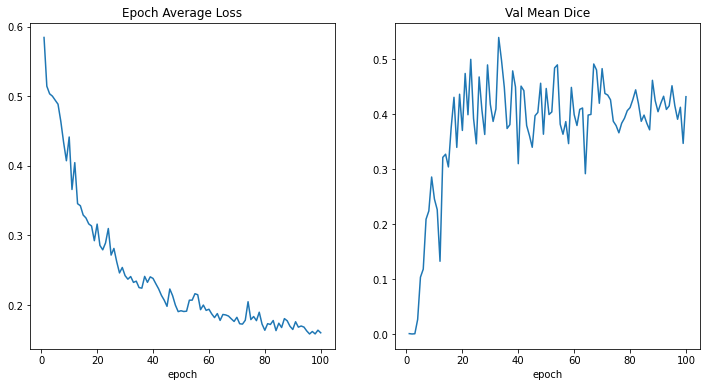

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig('model_03_graph.png')
plt.show()
# plt.savefig(PATH_NAME+'model.png')

Output shape: torch.Size([1, 2, 128, 128, 64])


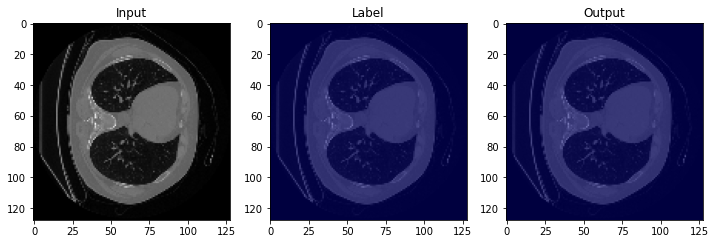

Output shape: torch.Size([1, 2, 128, 128, 64])


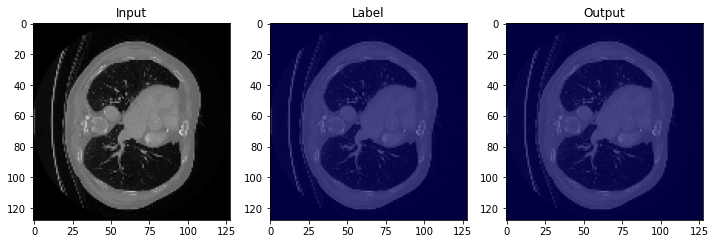

Output shape: torch.Size([1, 2, 128, 128, 64])


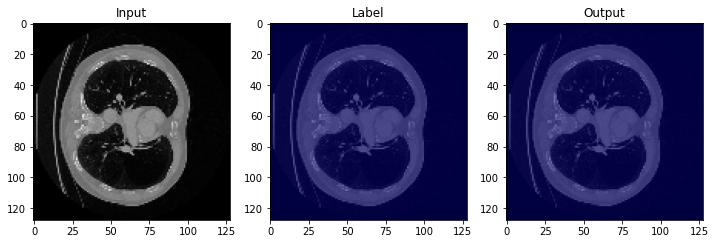

Output shape: torch.Size([1, 2, 128, 128, 64])


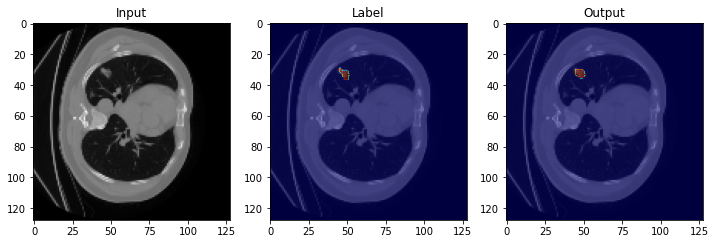

Output shape: torch.Size([1, 2, 128, 128, 64])


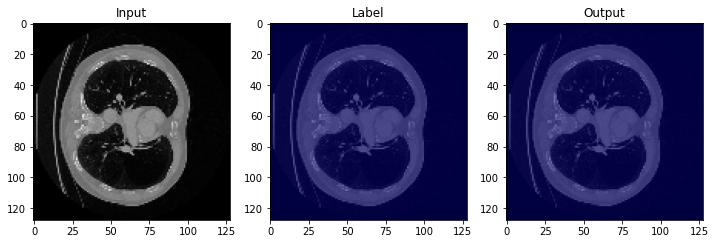

Output shape: torch.Size([1, 2, 128, 128, 64])


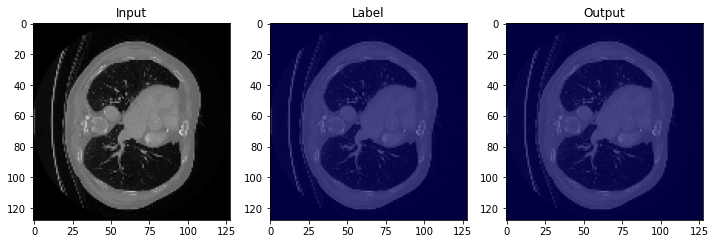

Output shape: torch.Size([1, 2, 128, 128, 64])


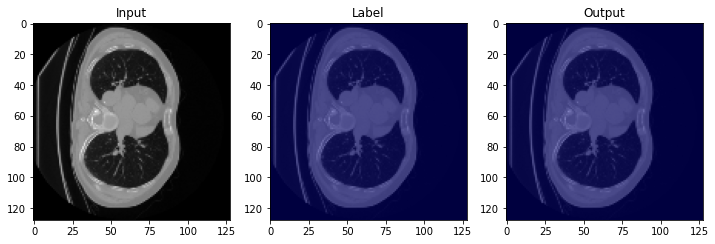

Output shape: torch.Size([1, 2, 128, 128, 64])


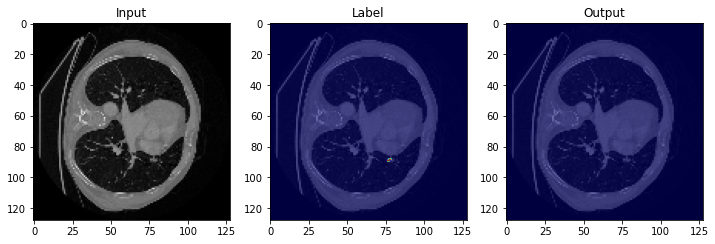

Output shape: torch.Size([1, 2, 128, 128, 64])


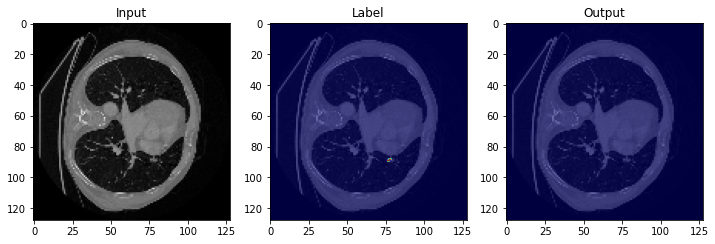

Output shape: torch.Size([1, 2, 128, 128, 64])


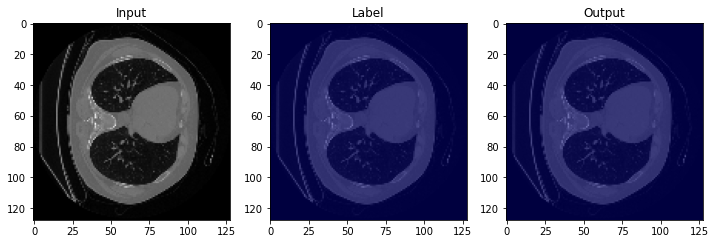

Output shape: torch.Size([1, 2, 128, 128, 64])


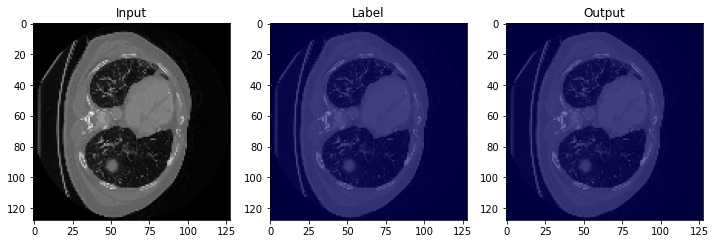

Output shape: torch.Size([1, 2, 128, 128, 64])


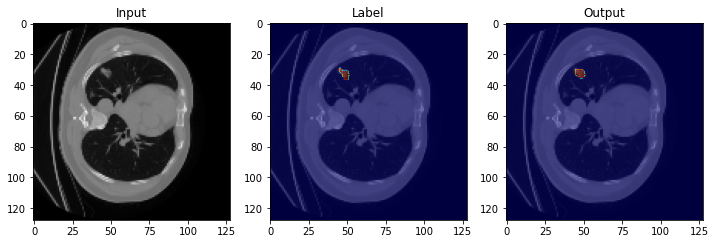

Output shape: torch.Size([1, 2, 128, 128, 64])


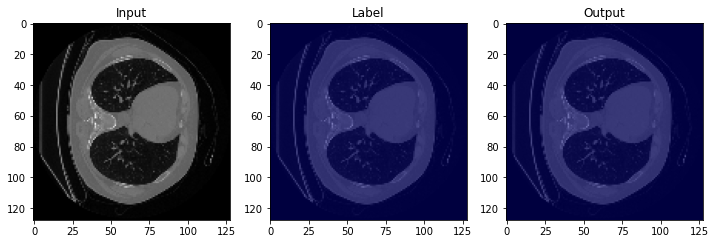

Output shape: torch.Size([1, 2, 128, 128, 64])


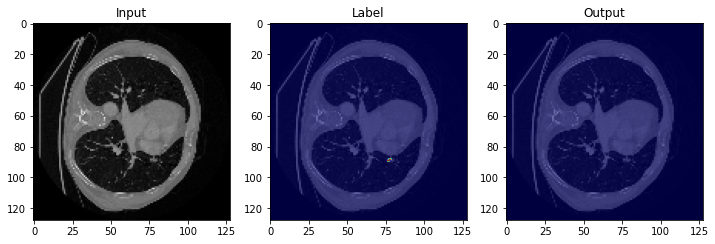

Output shape: torch.Size([1, 2, 128, 128, 64])


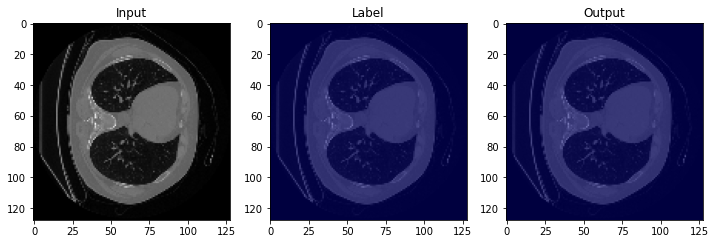

Output shape: torch.Size([1, 2, 128, 128, 64])


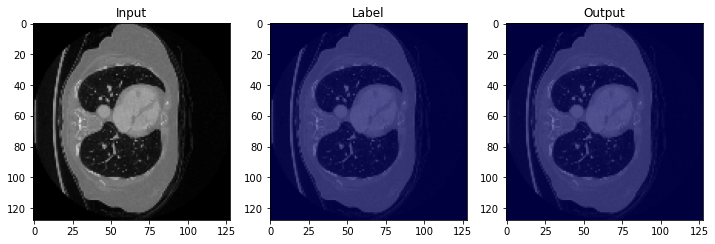

Output shape: torch.Size([1, 2, 128, 128, 64])


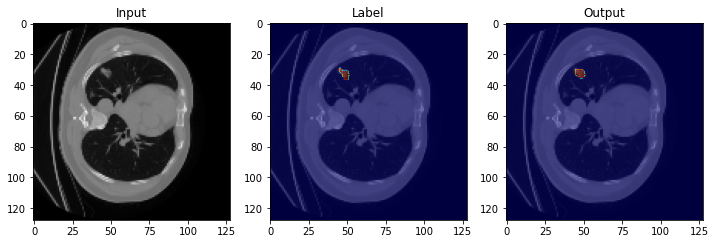

Output shape: torch.Size([1, 2, 128, 128, 64])


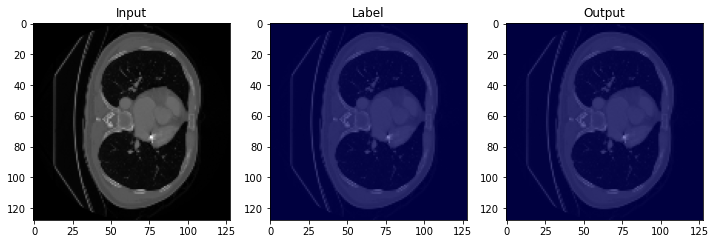

Output shape: torch.Size([1, 2, 128, 128, 64])


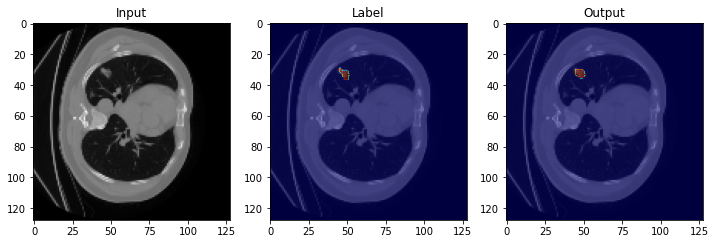

Output shape: torch.Size([1, 2, 128, 128, 64])


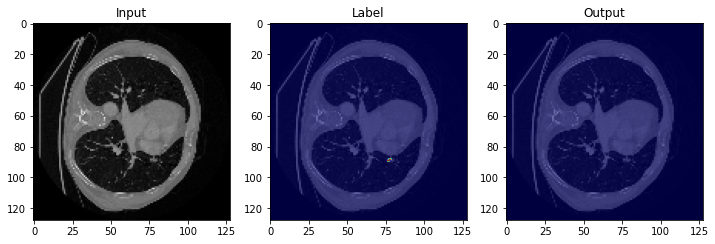

Output shape: torch.Size([1, 2, 128, 128, 64])


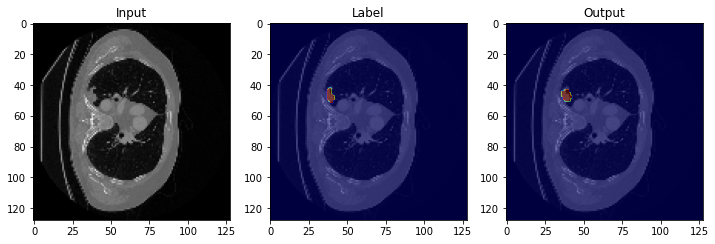

Output shape: torch.Size([1, 2, 128, 128, 64])


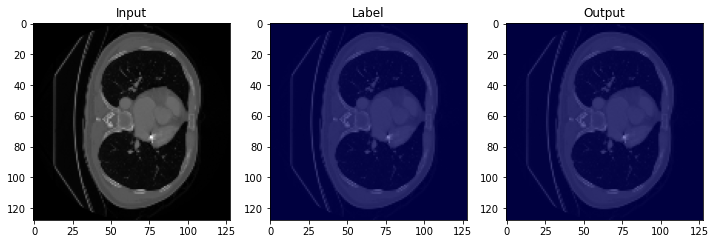

Output shape: torch.Size([1, 2, 128, 128, 64])


Output shape: torch.Size([1, 2, 128, 128, 64])


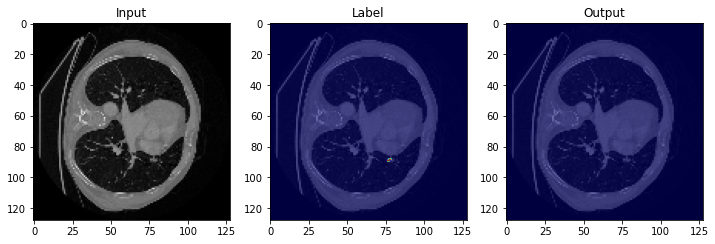

Output shape: torch.Size([1, 2, 128, 128, 64])


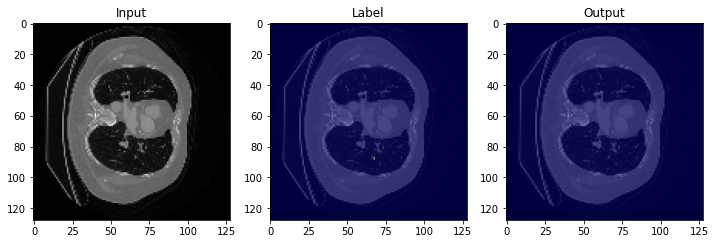

Output shape: torch.Size([1, 2, 128, 128, 64])


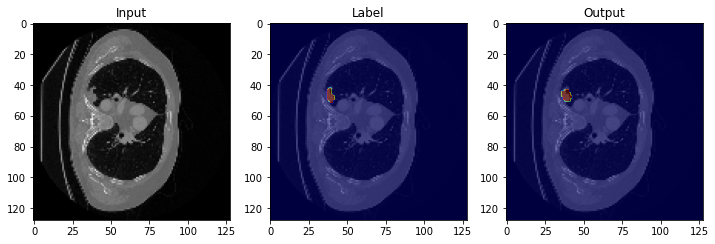

Output shape: torch.Size([1, 2, 128, 128, 64])


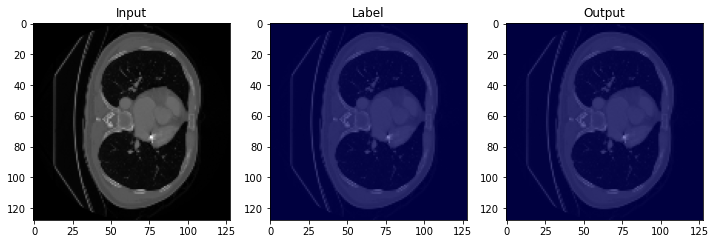

Output shape: torch.Size([1, 2, 128, 128, 64])


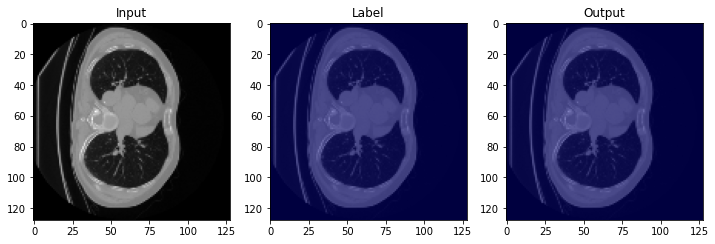

Output shape: torch.Size([1, 2, 128, 128, 64])


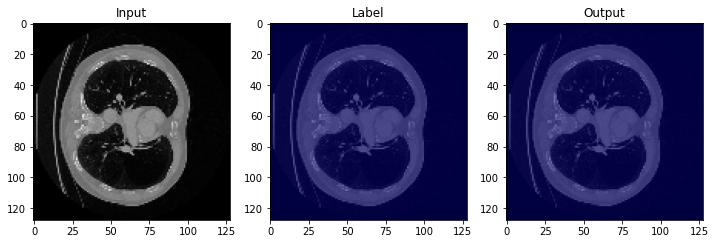

Output shape: torch.Size([1, 2, 128, 128, 64])


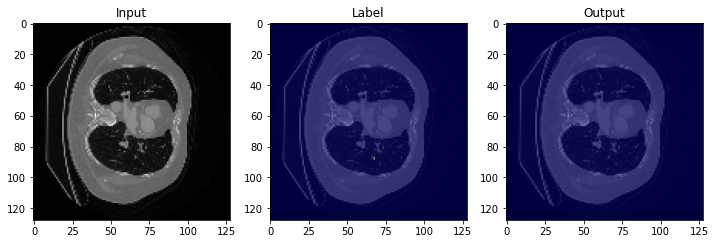

Output shape: torch.Size([1, 2, 128, 128, 64])


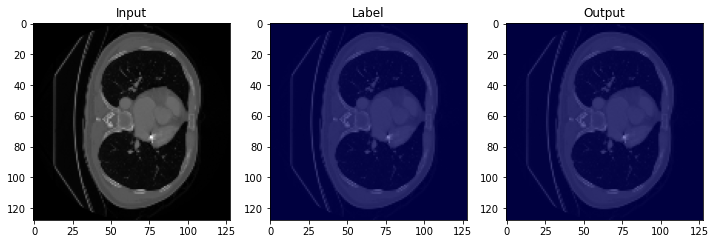

Output shape: torch.Size([1, 2, 128, 128, 64])


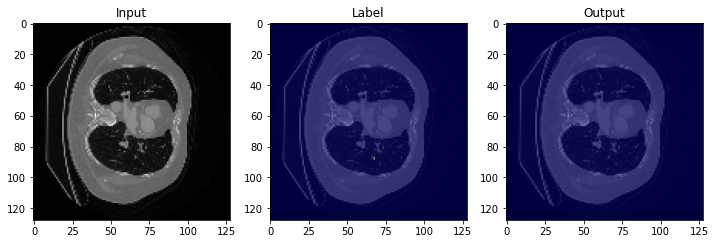

Output shape: torch.Size([1, 2, 128, 128, 64])


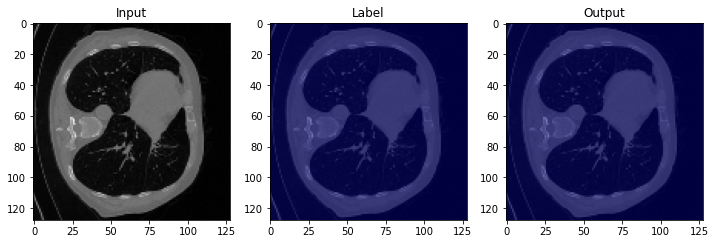

Output shape: torch.Size([1, 2, 128, 128, 64])


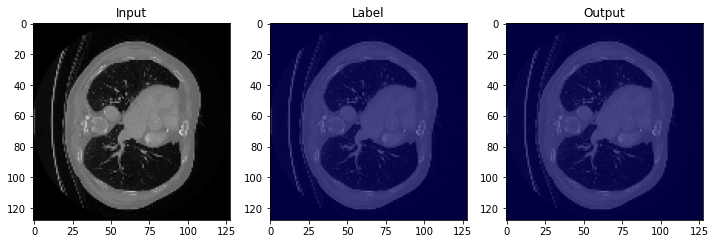

Output shape: torch.Size([1, 2, 128, 128, 64])


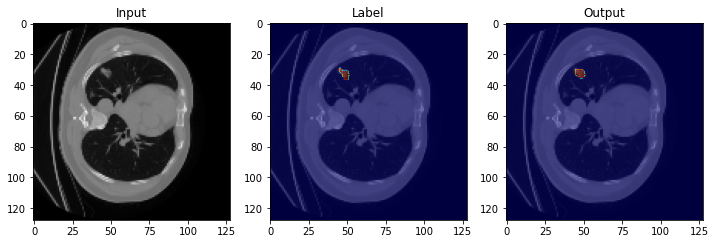

Output shape: torch.Size([1, 2, 128, 128, 64])


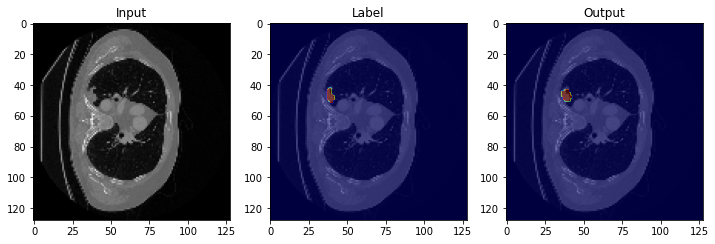

Output shape: torch.Size([1, 2, 128, 128, 64])


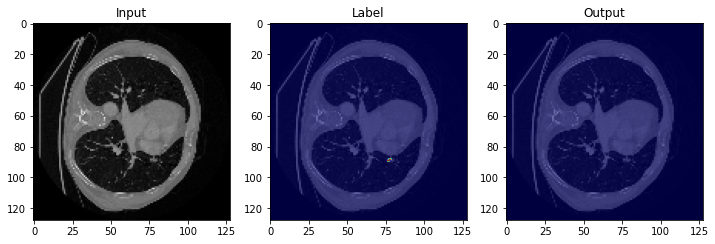

Output shape: torch.Size([1, 2, 128, 128, 64])


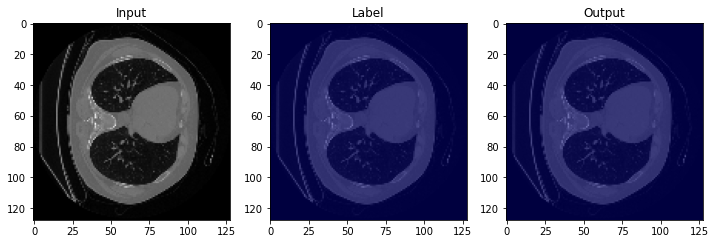

Output shape: torch.Size([1, 2, 128, 128, 64])


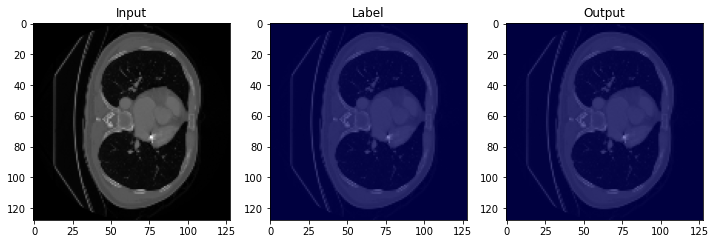

Output shape: torch.Size([1, 2, 128, 128, 64])


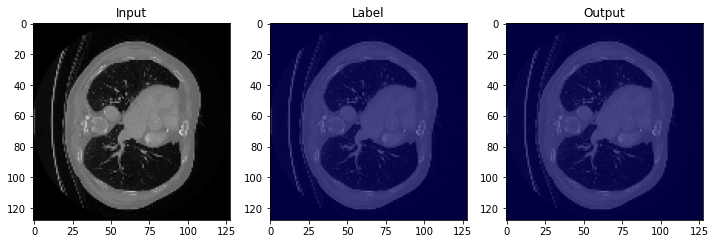

Output shape: torch.Size([1, 2, 128, 128, 64])


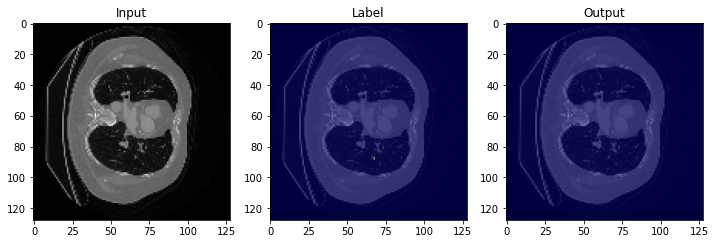

Output shape: torch.Size([1, 2, 128, 128, 64])


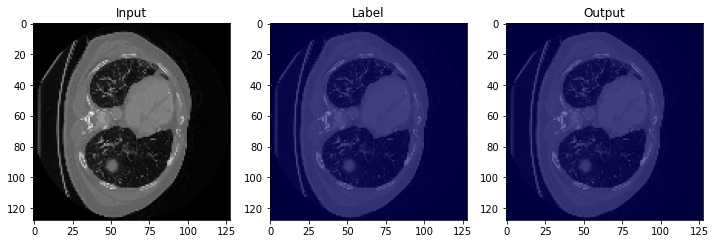

Output shape: torch.Size([1, 2, 128, 128, 64])


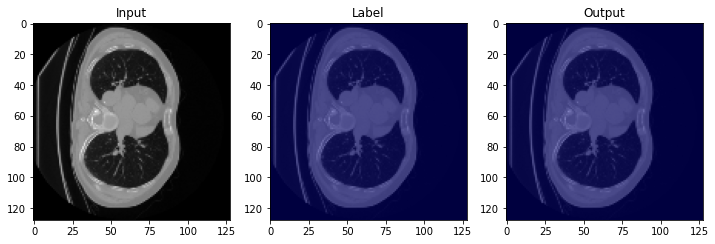

Output shape: torch.Size([1, 2, 128, 128, 64])


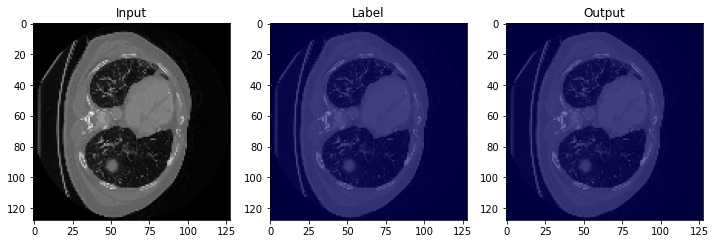

Output shape: torch.Size([1, 2, 128, 128, 64])


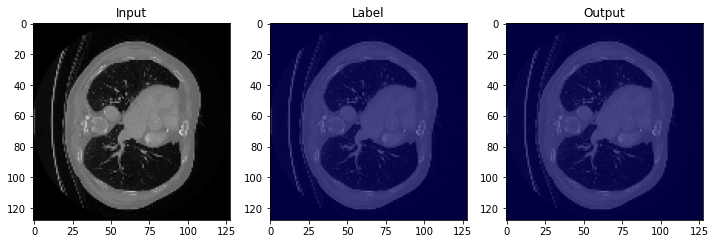

Output shape: torch.Size([1, 2, 128, 128, 64])


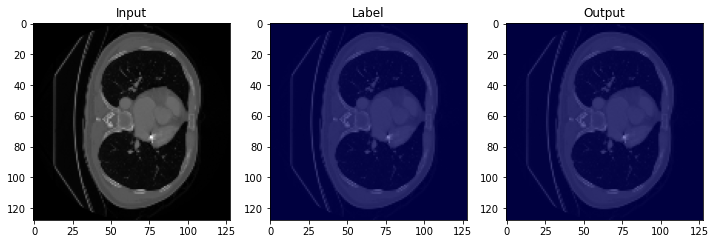

Output shape: torch.Size([1, 2, 128, 128, 64])


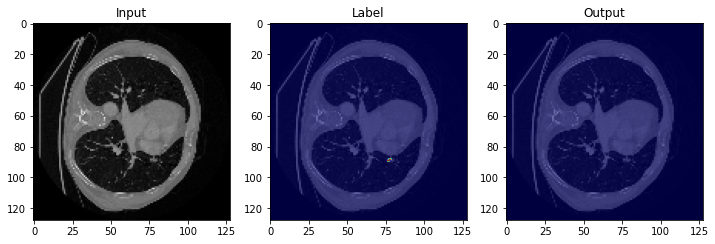

Output shape: torch.Size([1, 2, 128, 128, 64])


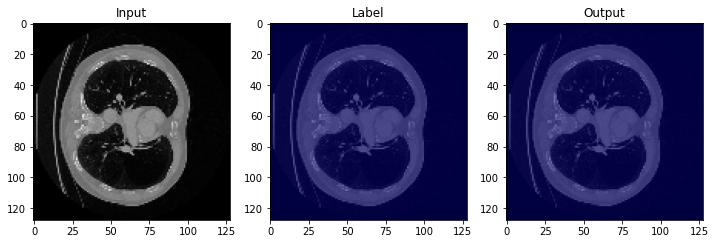

Output shape: torch.Size([1, 2, 128, 128, 64])


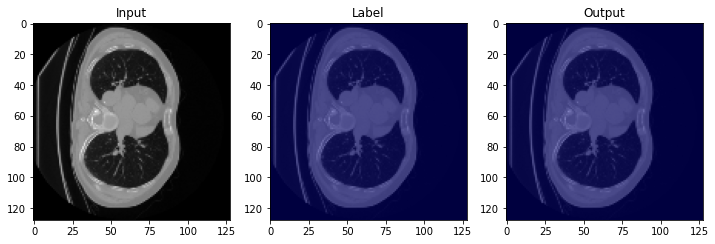

Output shape: torch.Size([1, 2, 128, 128, 64])


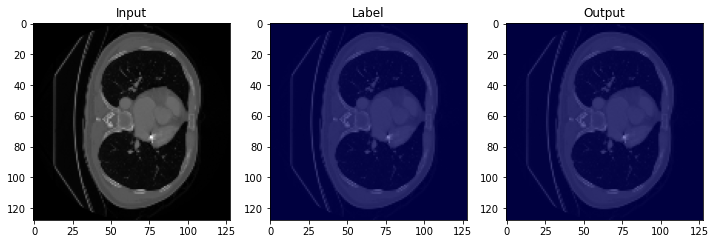

In [ ]:
def predict(image, label, model):
    with torch.no_grad():
      output = model(image)
      output = torch.nn.Softmax()(output)
      output = torch.round(output)

      print(f"Output shape: {output.shape}")

      slide = 28
      plt.figure("Test Model", (12, 12))

      plt.subplot(1, 3, 1)
      plt.title("Input")
      plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

      plt.subplot(1, 3, 2)
      plt.title("Label")
      plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
      plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

      plt.subplot(1, 3, 3)
      plt.title("Output")
      plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
      plt.imshow(output[0, 1, :, :, slide], cmap = 'jet', alpha = 0.5)

      plt.show()

for i in range(50):
    checker = first(val_loader)
    image, label = checker['image'], checker['label']
    predict(image, label, model)